<a href="https://colab.research.google.com/github/gvigkannan/COVID_CXR/blob/main/Bixia_CohenCOVID_All.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
## Author: Vignesh Kannan
## Notebook Objective:
## To use the COVID Images from Cohen and use the associated Brixia scores to get a prediction.


In [113]:
from __future__ import print_function, division
import numpy as np
import time
import os 
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import glob
import pandas as pd
import csv
from PIL import Image, ImageOps
import cv2

In [114]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision, torchsummary
from torchvision import datasets, models, transforms as T
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [115]:
## Downloading Torch XRay vision Models
!pip install torchxrayvision
import torchxrayvision as xrv

In [116]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
## Hyperparams!
EPOCHS = 150
BATCH_SIZE = 32
LEARNING_RATE = 0.001


## EDA and Preprocessing

In [118]:
## Loading the dataset
data_dir = "/content/drive/MyDrive/Cohen-Covid-Images/ONLY_COVID-Pneumonia"
data_fnames = os.listdir(data_dir)
annot_fname = "/content/drive/MyDrive/Cohen-Covid-Images/Brixia_COVID_Cohen.csv"
annot_data = pd.read_csv(annot_fname)

In [119]:
annot_data

,Unnamed: 0,filename,S-A,S-B,S-C,S-D,S-E,S-F,S-Global,J-A,J-B,J-C,J-D,J-E,J-F,J-Global
0,0,6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg,3.0,3.0,3.0,3.0,3.0,3.0,18.0,2.0,3.0,3.0,3.0,3.0,3.0,17.0
1,1,covid-19-pneumonia-12.jpg,2.0,2.0,3.0,2.0,3.0,2.0,14.0,3.0,3.0,3.0,2.0,3.0,3.0,17.0
2,2,covid-19-rapidly-progressive-acute-respiratory...,2.0,3.0,3.0,2.0,3.0,3.0,16.0,2.0,2.0,3.0,2.0,3.0,3.0,15.0
3,3,F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg,3.0,3.0,3.0,2.0,2.0,3.0,16.0,2.0,3.0,3.0,2.0,2.0,2.0,14.0
4,4,31BA3780-2323-493F-8AED-62081B9C383B.jpeg,2.0,3.0,3.0,2.0,3.0,3.0,16.0,2.0,3.0,3.0,1.0,2.0,3.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,nejmoa2001191_f1-PA.jpeg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,61,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,62,1-s2.0-S1684118220300682-main.pdf-002-a1.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,63,1-s2.0-S1684118220300682-main.pdf-002-a2.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
brixia_cohen_covid = annot_data.loc[annot_data['filename'].isin(data_fnames)]
# brixia_cohen_covid.to_csv("Brixia_COVID_Cohen.csv")

In [121]:
print(len(data_fnames))
print(data_fnames[0])

65
covid-19-pneumonia-14-PA.png


In [122]:
## Selecting just the Seniority and Junior Scores
brixia_cohen_covid = brixia_cohen_covid[['filename','S-Global']]
brixia_cohen_covid

,filename,S-Global
0,6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg,18.0
1,covid-19-pneumonia-12.jpg,14.0
2,covid-19-rapidly-progressive-acute-respiratory...,16.0
3,F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg,16.0
4,31BA3780-2323-493F-8AED-62081B9C383B.jpeg,16.0
...,...,...
60,nejmoa2001191_f1-PA.jpeg,0.0
61,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...,0.0
62,1-s2.0-S1684118220300682-main.pdf-002-a1.png,0.0
63,1-s2.0-S1684118220300682-main.pdf-002-a2.png,0.0


Cell Execution:  0.3891122341156006


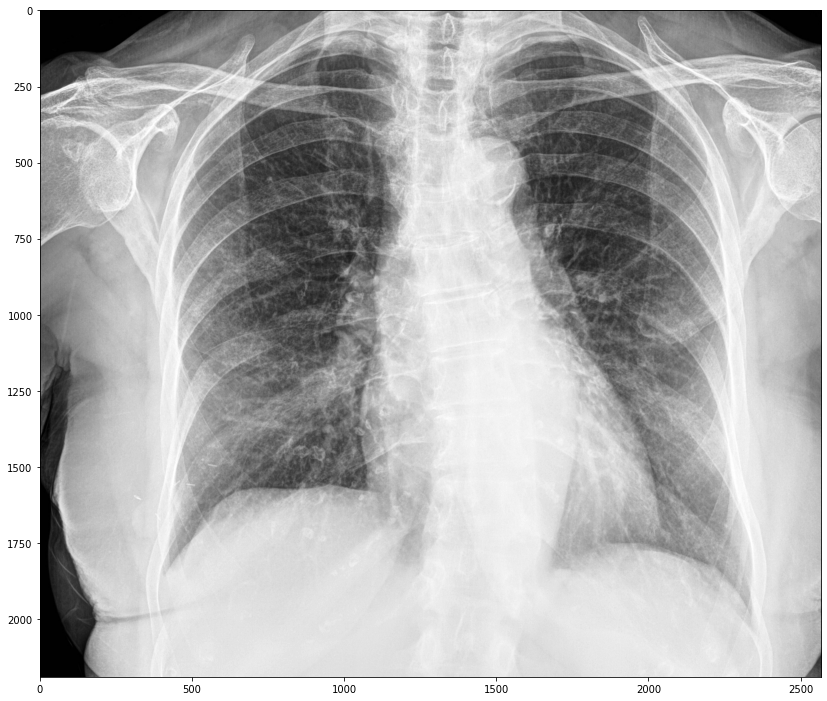

In [123]:
start_cell = time.time()
plt.figure(figsize = (14, 14))
img_pil = ImageOps.grayscale(Image.open(os.path.join(data_dir, data_fnames[0])))
img_cv2 = cv2.imread(os.path.join(data_dir, data_fnames[0]), cv2.IMREAD_GRAYSCALE)
plt.imshow(img_pil, cmap = 'gray')
np.shape(img_pil) ## Problem. Models expect a single channel
print("Cell Execution: ", time.time() - start_cell)

In [124]:
data_fnames[0]

'covid-19-pneumonia-14-PA.png'

Cell Execution:  0.20578289031982422


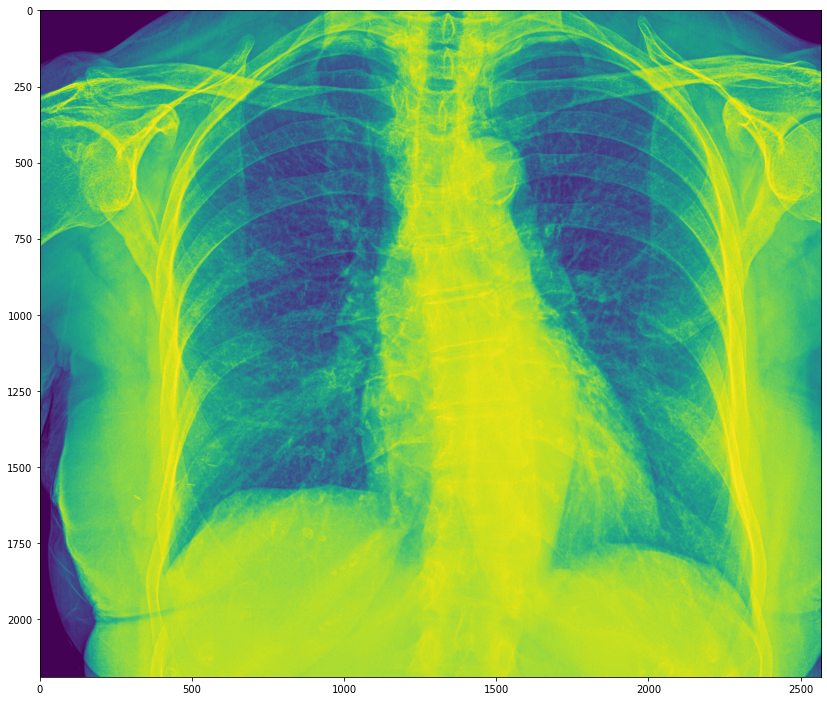

In [125]:
## For the purpose of comparison. Much faster
start_cell = time.time()
data_temp = data_fnames[0]
img_cv2 = cv2.imread(os.path.join(data_dir, data_temp), cv2.IMREAD_GRAYSCALE)
plt.figure(figsize = (14, 14))
plt.imshow(img_cv2)
print("Cell Execution: ", time.time() - start_cell)

Cell Execution:  0.3092029094696045


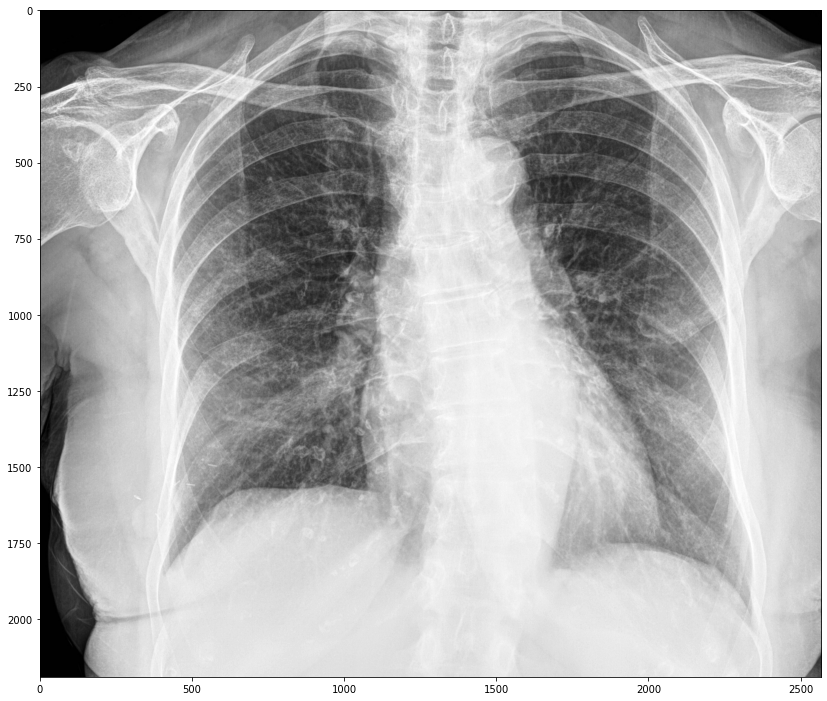

In [126]:
## For the purpose of comparison. Much faster
start_cell = time.time()
data_temp = data_fnames[0]
img_cv2 = cv2.imread(os.path.join(data_dir, data_temp), cv2.IMREAD_GRAYSCALE)
plt.figure(figsize = (14, 14))
plt.imshow(img_cv2, cmap = 'gray')
print("Cell Execution: ", time.time() - start_cell)

In [127]:
# class Brixia_CCOVID_Dataset(Dataset):
#     """ Files for the COVID Cohen Dataset """

#     def __init__(self, data_dir, annot_dir, transform = None):
#         """ Read Images and c """



In [128]:
def load_img(filename, target_size = 224):
  """
  Load and resize the grayscale image.
  :param filename: path/filename
  :param target_size: output shape of image
  :return: loaded images as (width, height, 1)
  """

  img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
  if img is None:
    print("File Couldn't be recognized: {}".format(filename))

  img = img / 255.0
  img = cv2.resize(img, (target_size, target_size))
  ## To match Pytorch Requirement
  img = np.reshape(img, (1, ) + img.shape )
  return img

In [129]:
## Testing
path = os.path.join(data_dir, data_temp)
img = load_img(path)
np.shape(img)

(1, 224, 224)

In [130]:
def shuffle_split(X, y, test_ratio = 0.2):
  """
  Shuffle and Split Dataset
  """
  lenData = len(y)
  ind = np.random.permutation(np.arange(lenData))
  X, y = X[ind], y[ind]
  testX, testY = X[:int(lenData*test_ratio)], y[:int(lenData*test_ratio)]
  trainX, trainY = X[int(lenData*test_ratio):], y[int(lenData*test_ratio):]
  return trainX, trainY, testX, testY



In [131]:
def get_data(img_dir, annot_dir, target_size = 224, test_size = 0.1, 
             random_state = 42, preprocessing = True, label = 'both'):
    """
    Get the train and test data from cohen dataset
    Adapted from Brixia Github
    """
    ## Load Annotation:
    annot_data = pd.read_csv(annot_dir)
    X = []
    y = []

    ## For all the images
    for idx in tqdm(annot_data.itertuples()):
      ## Loading Images:
      img = load_img(os.path.join(img_dir, idx.filename), target_size)
      ##To do. Implement Equalize
      y.append([idx[8], idx[15]])
      X.append(img)
    X = np.asarray(X).astype(np.float32)
    y = np.asarray(y).astype(np.float32) 
    len_data = len(y)
    # lengths = [int(len_data*(1-test_size)), int(len_data*test_size)]
    trainX, trainY, testX, testY = shuffle_split(X, y, test_ratio = 0.1)
    trainX, trainY, valX, valY = shuffle_split(trainX, trainY, test_ratio = 0.1)
    # dataset = Dataset(X, y)
    # train, test = random_split(dataset, lengths)
    return (trainX, trainY), (valX, valY), (testX, testY)
    




In [132]:
## Dataset Hyperparams
batch_size = BATCH_SIZE

In [133]:
data_dir = "/content/drive/MyDrive/Cohen-Covid-Images/ONLY_COVID-Pneumonia"
annot_fname = "/content/drive/MyDrive/Cohen-Covid-Images/Brixia_COVID_Cohen.csv"

(trainX, trainY), (valX, valY), (testX, testY) = get_data(img_dir = data_dir, annot_dir = annot_fname, preprocessing = False )


In [134]:
def get_dl(X, y, batch_size, train = False):
  """ Convert dataset into Tensor Dataset and then return it's dataloader """
  dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
  if train: ## We wish to prioritize randomization during training
    return DataLoader(dataset, batch_size, shuffle = True)
  else:
    return DataLoader(dataset, batch_size*2, shuffle = False)


In [135]:
train_dl = get_dl(trainX, trainY, batch_size, train = True)
val_dl = get_dl(valX, valY, batch_size, train = False)
test_dl = get_dl(testX, testY, batch_size, train = False)
dataloaders = {'train': train_dl,  'val': val_dl,  'test': test_dl}
data_sizes = {'train': len(trainY),  'val': len(valY),  'test': len(testY)}

In [136]:
data_sizes

{'test': 6, 'train': 54, 'val': 5}

In [137]:
## Creating an Instance of DataLoader!
# train_dl = DataLoader(data, batch_size = 8, shuffle = True)
# X, y = next(iter(train_dl))
# print(np.shape(X))
# print(np.shape(y))

In [138]:
## Trial!
# for idx in tqdm(annot_data.itertuples()):
#   print(idx.filename)
#   print(idx[8])
#   break

## Model Related

In [139]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_brixia = xrv.models.DenseNet(weights = 'all')
for param in model_brixia.parameters():
  param.requires_grad = False
model_brixia.op_threshs = None
model_brixia.to(device)

XRV-DenseNet121-all

In [140]:
print(model_brixia)

XRV-DenseNet121-all


In [141]:
torchsummary.summary(model_brixia, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11           [-1, 96, 56, 56]             192
             ReLU-12           [-1, 96, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          12,288
      BatchNorm2d-14          [-1, 128,

In [142]:
model_brixia.classifier = nn.Linear(in_features = 1024,
                                  out_features = 1)
model_brixia.to(device)

XRV-DenseNet121-all

In [143]:
# torchsummary.summary(model_brixia, (1, 224, 224))

In [144]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_brixia.parameters(), lr = LEARNING_RATE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [145]:
## To do: Training Script!
def train_model(model, criterion, optimizer, scheduler, dataloaders, numEpochs):
  """ Simple Train Function for PyTorch Model. Adapted from PyTorch tutorials """
  start_time = time.time()

  best_WandB = copy.deepcopy(model.state_dict())
  best_loss = np.inf 
  
  ## For all the epochs:
  for epoch in tqdm(range(numEpochs)):
    start_epoch = time.time()
    print("Epoch {}/{}".format(epoch + 1, numEpochs))
    print("*"*10)

    ## For each phase: train vs val
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      ## Tracking loss
      epoch_loss = 0.0

      ## For all phase data:
      for imgs, values in dataloaders[phase]:
        imgs = imgs.to(device)
        values = values.to(device)

        ## Zero the gradients
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, values)

        ## Forward Prop
        with torch.set_grad_enabled(phase == 'train'):
          ## Backward Prop
          if phase == 'train':
            loss.backward()
            optimizer.step()

        ## Epoch Stats
        epoch_loss += loss.item() * imgs.size(0)
      ## After every epoch:
      if phase == 'train':
        scheduler.step()
      epoch_loss = epoch_loss / data_sizes[phase]
      print("{}\tLoss: {:.4f}\tTime: {:.4f}".format(phase, epoch_loss, time.time() - start_epoch))
      print("")
      ## Check for loss: ## We don't check for validation loss
      ## Need to write a function for rmse 
      if phase == 'val' and best_loss > epoch_loss:
        best_loss = epoch_loss
        best_WandB = copy.deepcopy(model.state_dict())
        print("New Best Model!")
        print()

  ## Loading best model
  print("Best MSE: {:.4f}".format(best_loss))
  print("Total Time: {:.4f}".format(time.time() - start_time)) 
  
  return model.load_state_dict(best_WandB)





In [146]:
model_brixia.to(device)
model_brixia = train_model(model_brixia, criterion, optimizer, lr_scheduler, dataloaders, EPOCHS)

Epoch 1/150
**********
train	Loss: 2.5639	Time: 0.2371

val	Loss: 2.7211	Time: 0.2677

New Best Model!

Epoch 2/150
**********
train	Loss: 2.3619	Time: 0.1896

val	Loss: 2.6293	Time: 0.2104

New Best Model!

Epoch 3/150
**********
train	Loss: 2.1668	Time: 0.1855

val	Loss: 2.5263	Time: 0.2081

New Best Model!

Epoch 4/150
**********
train	Loss: 2.0147	Time: 0.1852

val	Loss: 2.4154	Time: 0.2083

New Best Model!

Epoch 5/150
**********
train	Loss: 1.8883	Time: 0.1905

val	Loss: 2.3026	Time: 0.2116

New Best Model!

Epoch 6/150
**********
train	Loss: 1.7511	Time: 0.1906

val	Loss: 2.1916	Time: 0.2117

New Best Model!

Epoch 7/150
**********
train	Loss: 1.6660	Time: 0.1844

val	Loss: 2.0817	Time: 0.2052

New Best Model!

Epoch 8/150
**********
train	Loss: 1.6018	Time: 0.1900

val	Loss: 2.0675	Time: 0.2115

New Best Model!

Epoch 9/150
**********
train	Loss: 1.5942	Time: 0.1860

val	Loss: 2.0522	Time: 0.2071

New Best Model!

Epoch 10/150
**********
train	Loss: 1.5813	Time: 0.1872

val	Los

In [146]:
## TO DO: Predict and Evaluation Function!